# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Obehi | Edeoghon | Obehi Edeoghon, 2024-11-01 | 4 Hours | 25 |
| Member 2: | Tirth | Panchal | Tirth Panchal 2024-11-02 | 4 hours | 25 |
| Member 3: | Kandarp | Rathod | Kandarp Rathod 2024-11-03 | 4 hours | 25 |
| Member 4: | Parth | Bhamani | Parth Bhamani 2024-11-04 | 4 hours | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

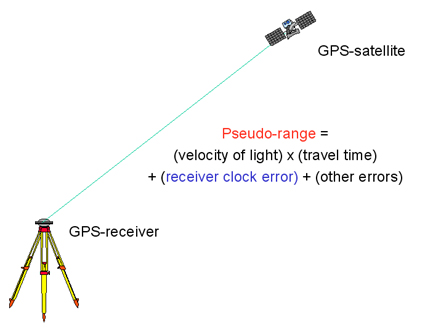

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):

    # Firstly calculate the geometric distances
    rho = euclidean_norm(r_pos, s_pos)

    # To get the predicted pseudorange with clock offset
    predicted_pseudorange = rho + cdT

    # Sum of squared residuals formular
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):

    # Firstly calculate the geometric distances
    rho = euclidean_norm(r_pos, s_pos)

    #To get the predicted pseudorange with clock offset
    predicted_pseudorange = rho + cdT

    residuals = pseudorange - predicted_pseudorange

    # Calculate partial derivatives
    grad_pos = -np.sum((residuals[:, None] * (r_pos - s_pos)) / rho[:, None], axis=0)
    grad_cdT = -np.sum(residuals)

    grad = np.append(grad_pos, grad_cdT)
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)


print(f"Optimized Parameters: {optimized_params}")
print(f"Final Position Errors of receiver: {np.linalg.norm(optimized_params[:3] - GroundTruth)}")
print(f"Number of Steps taken for Convergence: {steps_count}")
print(f"Final Cost value: {arr_cost[-1]}")
print(f"Final Gradient values: {arr_grad[-1]}")



Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248543e+06  6.46899086e+00]
Final Position Errors of receiver: 5.426942689562014
Number of Steps taken for Convergence: 588
Final Cost value: 6.197037218576748
Final Gradient values: [ 0.00011259  0.00062736 -0.00192816 -0.0010931 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

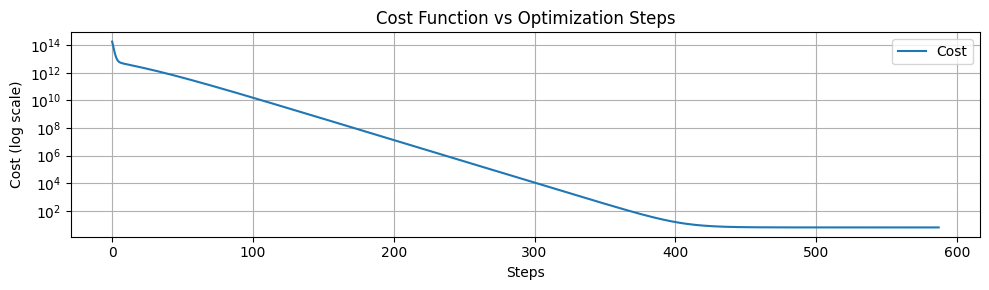

The cost decreases gradually as the gradient descent progresses, indicating that the estimates are converging towards the optimal solution.
The cost function also shows an exponential decay pattern, indicating that the optimization converges quickly in the beginning and then slows down as it approaches the minimum.


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

ax.semilogy(arr_cost, label="Cost")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (log scale)")
ax.set_title("Cost Function vs Optimization Steps")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print("The cost decreases gradually as the gradient descent progresses, indicating that the estimates are converging towards the optimal solution.")
print ("The cost function also shows an exponential decay pattern, indicating that the optimization converges quickly in the beginning and then slows down as it approaches the minimum.")

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

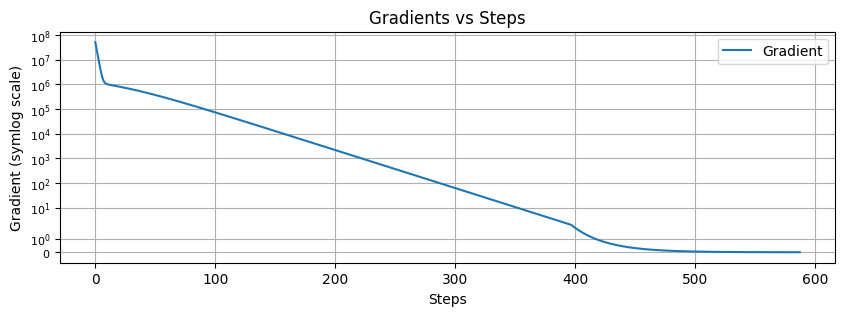

The gradient norm decreases as the algorithm converges, indicating that the descent is moving toward a minimum.


In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(np.arange(len(arr_grad)), np.linalg.norm(arr_grad, axis=1), label="Gradient", scaley=True)
ax.set_yscale("symlog")
ax.tick_params(axis="y", labelsize=8)
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient (symlog scale)")
ax.set_title("Gradients vs Steps")
ax.grid(True)
ax.legend()
plt.show()
# Comment on the pattern
print("The gradient norm decreases as the algorithm converges, indicating that the descent is moving toward a minimum.")

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

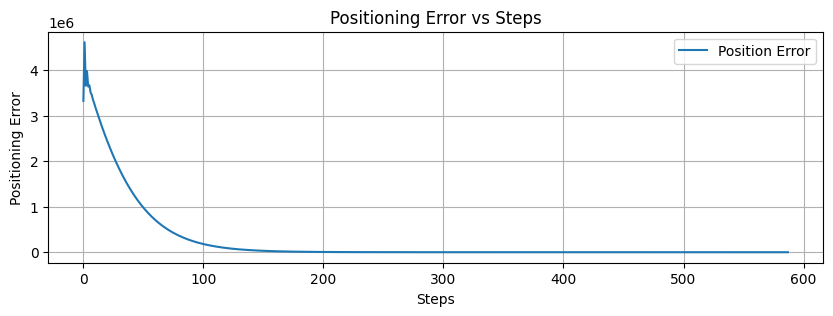

Positioning error decreases steadily as the gradient descent approaches the true position of the receiver.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
position_errors = [np.linalg.norm(error) for error in arr_err]
ax.plot(position_errors, label="Position Error")
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error")
ax.set_title("Positioning Error vs Steps")
ax.grid(True)
ax.legend()
plt.show()
print("Positioning error decreases steadily as the gradient descent approaches the true position of the receiver.")

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01)
print("Optimized parameters (LR=0.01):", optimized_params_2)
print("Steps taken:", steps_count)
print("Final position error:", np.linalg.norm(optimized_params_2[:3] - GroundTruth))
print("Final cost:", arr_cost[-1])

Converged !
Optimized parameters (LR=0.01): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46239527e+00]
Steps taken: 5652
Final position error: 5.416755571078921
Final cost: 6.197166705529241


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001)
print("Optimized parameters (LR=0.001):", optimized_params_3)
print("Steps taken:", steps_count)
print("Final position error:", np.linalg.norm(optimized_params_3[:3] - GroundTruth))
print("Final cost:", arr_cost[-1])

Optimized parameters (LR=0.001): [-1622126.12222408 -3588680.62330238  4759183.15248715  -110181.78568974]
Steps taken: 0
Final position error: 203606.70495775464
Final cost: 18496079730.210545


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

In [ ]:
print("Q1. Comment on the difference that you notice after changing the learning rate.")
print("Ans -")
print("Using a higher learning rate (like 0.01) means the algorithm learns faster but might miss the mark by overshooting the minimum. On the other hand, a lower learning rate (like 0.001) means slower progress, but it's more stable and precise. It's a bit like driving: speeding might get you there quicker, but it increases the risk of missing your turn, while going slower is steadier and safer.")

Q1. Comment on the difference that you notice after changing the learning rate.
Ans -
Using a higher learning rate (like 0.01) means the algorithm learns faster but might miss the mark by overshooting the minimum. On the other hand, a lower learning rate (like 0.001) means slower progress, but it's more stable and precise. It's a bit like driving: speeding might get you there quicker, but it increases the risk of missing your turn, while going slower is steadier and safer.


In [ ]:
print("Q2. What is the difference between LSE and Gradient Descent?")
print("Ans -")
print("LSE (Least Squares Estimation) quickly finds the best-fit parameters by minimizing the residuals in a straightforward way, perfect for linear systems. On the other hand, Gradient Descent is more of a step-by-step approach, gradually adjusting the parameters based on the gradient. It's slower but shines when dealing with complex, nonlinear problems. Think of LSE as a direct shortcut, while Gradient Descent is like climbing a winding path to reach the top.")

Q2. What is the difference between LSE and Gradient Descent?
Ans -
LSE (Least Squares Estimation) quickly finds the best-fit parameters by minimizing the residuals in a straightforward way, perfect for linear systems. On the other hand, Gradient Descent is more of a step-by-step approach, gradually adjusting the parameters based on the gradient. It's slower but shines when dealing with complex, nonlinear problems. Think of LSE as a direct shortcut, while Gradient Descent is like climbing a winding path to reach the top.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets
# TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


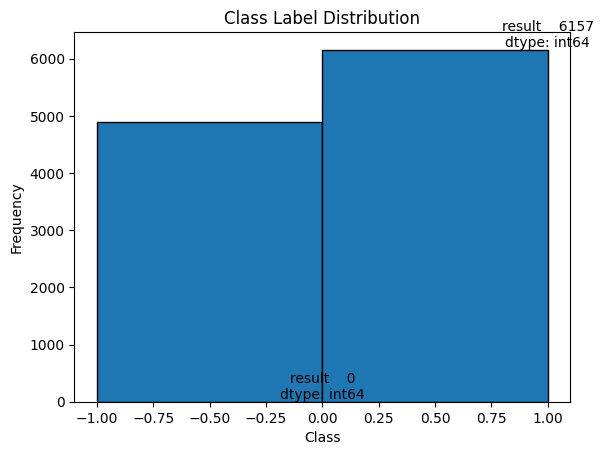

In [4]:
# TO DO: Check the class distribution of y (2 mark)
plt.hist(y, bins=2, edgecolor='black', align='mid')
plt.title('Class Label Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Display exact values for each bin in the histogram
for i in range(2):
    plt.text(i, np.sum(y == i), str(np.sum(y == i)), ha='center', va='bottom')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [9]:
# Add this import statement at the beginning of your code
from sklearn.model_selection import train_test_split

# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# Train and evaluate on the full dataset
model.fit(X, y)
train_accuracy_full = model.score(X, y)
y_pred_full = model.predict(X)
test_accuracy_full = model.score(X, y)  # Same as training set in this case

# Train and evaluate on the first two columns
# Use .iloc to select the first two columns of the DataFrame
model.fit(X.iloc[:, :2], y)
train_accuracy_2_cols = model.score(X.iloc[:, :2], y)
y_pred_2_cols = model.predict(X.iloc[:, :2])
test_accuracy_2_cols = model.score(X.iloc[:, :2], y)

# Train and evaluate on the smaller dataset
model.fit(X_small, y_small)
train_accuracy_small = model.score(X_small, y_small)
y_pred_small = model.predict(X_small)
test_accuracy_small = model.score(X_small, y_small)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [13]:
from sklearn.metrics import log_loss
# Full dataset
log_loss_full = log_loss(y, model.predict_proba(X))

# First two columns dataset
# Retrain the model using only the first two columns,
# then calculate the log loss using the same two columns
model_2_cols = LogisticRegression(max_iter=2000) # Create a separate model
model_2_cols.fit(X.iloc[:, :2], y)
log_loss_2_cols = log_loss(y, model_2_cols.predict_proba(X.iloc[:, :2]))

# Smaller dataset
log_loss_small = log_loss(y_small, model.predict_proba(X_small))

# Print results for the full dataset
print(f"Full dataset - Training Accuracy: {train_accuracy_full}, Testing Accuracy: {test_accuracy_full}, Log Loss: {log_loss_full}")

# Print results for the first two columns dataset
print(f"First two columns - Training Accuracy: {train_accuracy_2_cols}, Testing Accuracy: {test_accuracy_2_cols}, Log Loss: {log_loss_2_cols}")

# Print results for the smaller dataset
print(f"Smaller dataset - Training Accuracy: {train_accuracy_small}, Testing Accuracy: {test_accuracy_small}, Log Loss: {log_loss_small}")

Full dataset - Training Accuracy: 0.9281772953414744, Testing Accuracy: 0.9281772953414744, Log Loss: 0.23010697504196673
First two columns - Training Accuracy: 0.5610131162369968, Testing Accuracy: 0.5610131162369968, Log Loss: 0.6802413971069344
Smaller dataset - Training Accuracy: 0.945619335347432, Testing Accuracy: 0.945619335347432, Log Loss: 0.15110976983690202


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [14]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
import pandas as pd

# Create a DataFrame to hold the results
results = pd.DataFrame({
    'Dataset': ['Full', 'First two columns', 'Small'],
    'Data size': [X.shape[0], X.iloc[:, :2].shape[0], X_small.shape[0]],
    'Training samples': [X.shape[0], X.iloc[:, :2].shape[0], X_small.shape[0]],
    'Testing samples': [0, 0, 0],  # Update accordingly if you split data into train/test
    'Training accuracy': [train_accuracy_full, train_accuracy_2_cols, train_accuracy_small],
    'Testing accuracy': [test_accuracy_full, test_accuracy_2_cols, test_accuracy_small],
    'Log loss': [log_loss_full, log_loss_2_cols, log_loss_small]
})

print(results)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



             Dataset  Data size  Training samples  Testing samples  \
0               Full      11055             11055                0   
1  First two columns      11055             11055                0   
2              Small        331               331                0   

   Training accuracy  Testing accuracy  Log loss  
0           0.928177          0.928177  0.230107  
1           0.561013          0.561013  0.680241  
2           0.945619          0.945619  0.151110  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

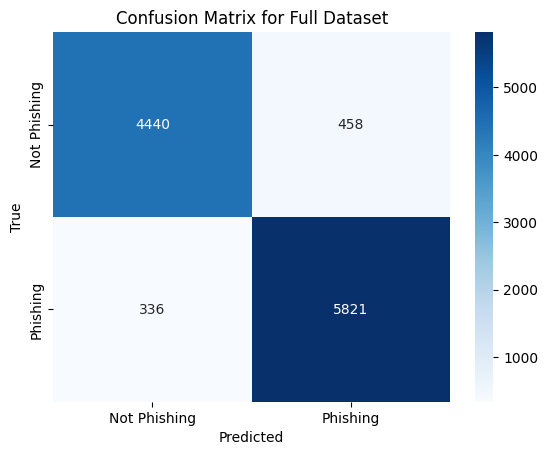

Classification Report for Full Dataset:
              precision    recall  f1-score   support

          -1       0.93      0.91      0.92      4898
           1       0.93      0.95      0.94      6157

    accuracy                           0.93     11055
   macro avg       0.93      0.93      0.93     11055
weighted avg       0.93      0.93      0.93     11055



In [16]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix and Classification Report for full dataset
conf_mat = confusion_matrix(y, y_pred_full)

# Plotting the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Full Dataset')
plt.show()

# Classification Report
print("Classification Report for Full Dataset:")
print(classification_report(y, y_pred_full))



Text(113.9222222222222, 0.5, 'true value')

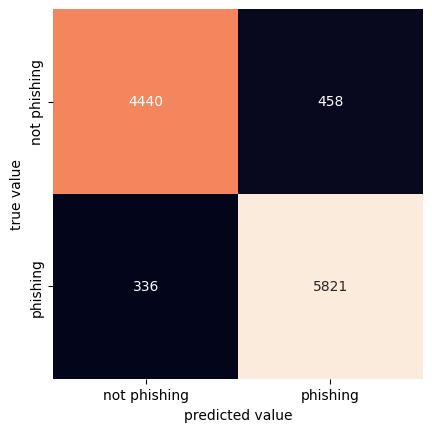

In [17]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [ ]:
# TO DO: Print classification report (2 marks)


### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [18]:
print("1. Is the dataset imbalanced? Does it affect model performance?")
print("Ans -")
print("When you look at the class label histogram and see that there’s a big difference between the number of phishing and non-phishing instances, it means the data is imbalanced. This imbalance can mess with the model's performance, making it more likely to lean towards predicting the majority class more often than it should.")
print("2. Does the model overfit or underfit for each of the 3 cases?")
print("Ans -")
print("If your model performs really well on the training data but poorly on the testing data, it might be overfitting, meaning it learned the training data too well and isn’t doing a good job with new data. On the other hand, if both the training and testing accuracies are low, your model might be underfitting, which usually happens when the model is too simple or there's not enough data or features for it to learn properly.")
print("3. How do the training and testing accuracy change depending on the amount of data used?")
print("Ans -")
print("When you have a smaller dataset, your model might end up memorizing the few examples it has, leading to higher training accuracy but not doing well on new data—this is overfitting. In contrast, with a larger dataset, the model usually gets better at understanding the overall patterns and generalizes more effectively.")
print("4. In this case, what do a false positive and a false negative represent? Which one is worse?")
print("Ans -")
print("If a non-phishing site gets wrongly flagged as a phishing site (false positive), legitimate sites could end up getting blocked. On the flip side, if a phishing site isn’t flagged and is mistaken for a safe site (false negative), users could get exposed to phishing, which is far more dangerous.")
print("5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this?")
print("Ans -")
print("To catch as many phishing sites as possible, we need to focus on high recall, even if it means sacrificing a bit of precision. This way, we minimize the chances of missing any phishing attempts and keep users safer.")
print("6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences?")
print("Ans -")
print("When log loss is low, it means the model is pretty confident in its predictions. If you see a higher log loss with a smaller dataset, it might indicate that the model's predictions are a bit unstable because there's not enough data to learn from.")

1. Is the dataset imbalanced? Does it affect model performance?
Ans -
When you look at the class label histogram and see that there’s a big difference between the number of phishing and non-phishing instances, it means the data is imbalanced. This imbalance can mess with the model's performance, making it more likely to lean towards predicting the majority class more often than it should.
2. Does the model overfit or underfit for each of the 3 cases?
Ans -
If your model performs really well on the training data but poorly on the testing data, it might be overfitting, meaning it learned the training data too well and isn’t doing a good job with new data. On the other hand, if both the training and testing accuracies are low, your model might be underfitting, which usually happens when the model is too simple or there's not enough data or features for it to learn properly.
3. How do the training and testing accuracy change depending on the amount of data used?
Ans -
When you have a small